In [107]:
#Imports the dataset from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashanknecrothapa/ames-housing-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\henri\.cache\kagglehub\datasets\shashanknecrothapa\ames-housing-dataset\versions\1


In [108]:
# Reads the csv file into a pandas dataframe
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
data = pd.read_csv(path + "/AmesHousing.csv")

# Bin the SalePrice for stratification (e.g., 10 bins)
data['SalePrice_bin'] = pd.qcut(data['SalePrice'], q=10, duplicates='drop', labels=False)

# Stratified split: 80% train, 20% test
trainData, testData = train_test_split(
    data,
    test_size=0.2,
    random_state=42,
    stratify=data['SalePrice_bin']
)

def proportions(s: pd.Series):
    return s.value_counts(normalize=True).sort_index()

prop_table = pd.DataFrame({
    'overall': proportions(data['SalePrice_bin']),
    'train':   proportions(trainData['SalePrice_bin']),
    'test':    proportions(testData['SalePrice_bin'])
})
display(prop_table)

# Drop the bin column after splitting
trainData = trainData.drop(columns=['SalePrice_bin'])
testData = testData.drop(columns=['SalePrice_bin'])


print("Train shape:", trainData.shape)
print("Test shape:", testData.shape)

,overall,train,test
SalePrice_bin,,,
0,0.100000,0.099829,0.100683
1,0.103413,0.103669,0.102389
2,0.100000,0.099829,0.100683
3,0.097952,0.098123,0.097270
4,0.099317,0.099403,0.098976
5,0.099317,0.099403,0.098976
6,0.100341,0.100256,0.100683
7,0.102048,0.101962,0.102389
8,0.097611,0.097696,0.097270


Train shape: (2344, 82)
Test shape: (586, 82)


In [109]:
# Prepearing data for training and testing
dfTest = pd.DataFrame(testData)
dfTrain = pd.DataFrame(trainData)

def clean_data(df, colsToRemove, threshold=0.9):
    dfClean = df.copy()
    dfClean.drop(columns=colsToRemove, inplace=True)

    na_frac = dfClean.isna().mean()
    cols_to_drop = na_frac[na_frac > threshold].index.tolist()
    dfClean.drop(columns=cols_to_drop)
    dfCleaned = dfClean.copy()
    for col in dfClean.columns:
        if dfClean[col].dtype == 'object':
            dfCleaned[col] = dfClean[col].fillna(dfCleaned[col].mode()[0])
        else:
            dfCleaned[col] = dfClean[col].fillna(dfCleaned[col].median())
    return dfCleaned

colsToRemove = ['Order', 'PID', 'Misc Val', 'Mo Sold', 'MS SubClass', 'Lot Frontage', 'Low Qual Fin SF', 
                'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Bedroom AbvGr', 'Kitchen AbvGr', 
                'TotRms AbvGrd', 'Yr Sold']

dfTrain = clean_data(dfTrain, colsToRemove=colsToRemove)
dfTest = clean_data(dfTest, colsToRemove=colsToRemove)


In [110]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
def feature_engineering(df):
    df['Remodeled'] = (df['Year Remod/Add'] - df['Year Built'])
    df['Total SF'] = (df['1st Flr SF'] + df['2nd Flr SF'] + df['Total Bsmt SF'] + df['Garage Area'])
    df['Total Bathrooms'] = (df['Full Bath'] + 0.5 * df['Half Bath'] + df['Bsmt Full Bath'] + 0.5 * df['Bsmt Half Bath'])
    df['Total Porch SF'] = (df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'])
    df['Has Pool'] = np.where(df['Pool Area'] > 0, 1, 0)
    df['Has Garage'] = np.where(df['Garage Area'] > 0, 1, 0)
    df['Has Fireplace'] = np.where(df['Fireplaces'] > 0, 1, 0)

    colsToRemove = ['Year Built', 'Year Remod/Add', 'Garage Yr Blt', '1st Flr SF', '2nd Flr SF',
                    'Total Bsmt SF', 'Garage Area', 'Full Bath', 'Half Bath', 'Bsmt Full Bath',
                    'Bsmt Half Bath', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
                    'Pool Area', 'Fireplaces']
    df.drop(columns=colsToRemove, inplace=True)
    display(df.head())
    return df

dfTrain = feature_engineering(dfTrain)
dfTest = feature_engineering(dfTest)

colsToRemove = ['MS Zoning', "Land Slope", 'Lot Shape', ]


,MS Zoning,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Gr Liv Area,Kitchen Qual,Functional,Fireplace Qu,Garage Type,Garage Finish,Garage Cars,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition,SalePrice,Remodeled,Total SF,Total Bathrooms,Total Porch SF,Has Pool,Has Garage,Has Fireplace
2248,RL,7540,Pave,Grvl,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,6,6,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.0,TA,TA,CBlock,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,912,TA,Typ,TA,Attchd,RFn,2.0,TA,TA,Y,0,Gd,MnPrv,Shed,WD,Normal,156000,0,2270.0,2.0,192,0,1,1
2579,RL,10152,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,Unf,GasA,Ex,Y,SBrkr,1124,TA,Typ,TA,Attchd,Fin,1.0,TA,TA,Y,0,Gd,MnPrv,Shed,WD,Normal,153000,38,2601.0,2.0,533,0,1,1
2691,RM,7518,Pave,Grvl,Reg,Lvl,AllPub,FR3,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,8,Gable,CompShg,AsbShng,Plywood,BrkFace,0.0,Fa,Gd,BrkTil,Fa,Fa,No,Unf,Unf,GasA,Gd,Y,SBrkr,1330,TA,Typ,Gd,Detchd,Unf,1.0,TA,TA,N,0,Gd,MnPrv,Shed,WD,Normal,116500,94,2116.0,1.0,117,0,1,0
1264,RL,12929,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,276.0,TA,TA,CBlock,TA,TA,Gd,GLQ,Unf,GasA,TA,Y,SBrkr,1081,TA,Typ,Gd,CarPort,Unf,1.0,TA,TA,Y,36,Gd,MnPrv,Shed,WD,Normal,148000,33,2563.0,2.0,82,0,1,0
1437,RL,9179,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,158.0,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,1790,Gd,Typ,Gd,Attchd,RFn,2.0,TA,TA,Y,0,Gd,MnPrv,Shed,WD,Abnorml,193000,0,3251.0,3.5,88,0,1,0


,MS Zoning,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Gr Liv Area,Kitchen Qual,Functional,Fireplace Qu,Garage Type,Garage Finish,Garage Cars,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition,SalePrice,Remodeled,Total SF,Total Bathrooms,Total Porch SF,Has Pool,Has Garage,Has Fireplace
795,RL,4235,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,ALQ,GasA,TA,Y,SBrkr,1049,Gd,Typ,Gd,Attchd,Fin,1.0,TA,TA,Y,0,Ex,MnPrv,Shed,WD,Normal,139500,0,2364.0,3.0,105,0,1,0
547,RL,10762,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,SawyerW,Norm,Norm,TwnhsE,2Story,6,6,Gable,CompShg,Plywood,Plywood,BrkFace,0.0,TA,TA,CBlock,Gd,TA,No,Unf,Unf,GasA,TA,Y,SBrkr,1217,TA,Typ,TA,Attchd,RFn,1.0,TA,TA,Y,0,Ex,MnPrv,Shed,WD,Normal,120000,0,2131.0,1.5,28,0,1,1
2470,RL,7733,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,6,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.0,TA,TA,PConc,TA,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,1142,Gd,Typ,Gd,Attchd,Unf,0.0,TA,TA,Y,4,Ex,MnPrv,Shed,WD,Normal,139500,0,2284.0,1.5,50,0,0,0
959,RL,13438,Pave,Grvl,IR1,HLS,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,1Story,9,5,Gable,CompShg,CemntBd,CmentBd,Stone,246.0,Ex,TA,CBlock,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,2036,Ex,Typ,Ex,Attchd,Fin,3.0,TA,TA,Y,90,Ex,MnPrv,Shed,WD,Normal,410000,0,5006.0,3.0,154,0,1,1
1979,RM,10800,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,4,7,Mansard,CompShg,VinylSd,VinylSd,BrkFace,0.0,TA,TA,BrkTil,Fa,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,1047,TA,Typ,Gd,Detchd,Unf,1.0,Fa,Fa,N,0,Ex,MnPrv,Shed,WD,Normal,100000,110,1961.0,1.0,0,0,1,0


In [111]:
# Seperated the first feature of the data set from the later features
# x contains all features found to be relevant for predicting sale price
# y contains only sale price
x_train = dfTrain.iloc[:, :-1].values
y_train = dfTrain.iloc[:, -1].values
x_test = dfTest.iloc[:, :-1].values
y_test = dfTest.iloc[:, -1].values


print ("x_train shape:", x_train.shape)
print(x_train)

x_train shape: (2344, 57)
[['RL' 7540 'Pave' ... 192 0 1]
 ['RL' 10152 'Pave' ... 533 0 1]
 ['RM' 7518 'Pave' ... 117 0 1]
 ...
 ['RL' 9308 'Pave' ... 0 0 1]
 ['RM' 6240 'Pave' ... 0 0 1]
 ['RL' 13891 'Pave' ... 229 0 1]]


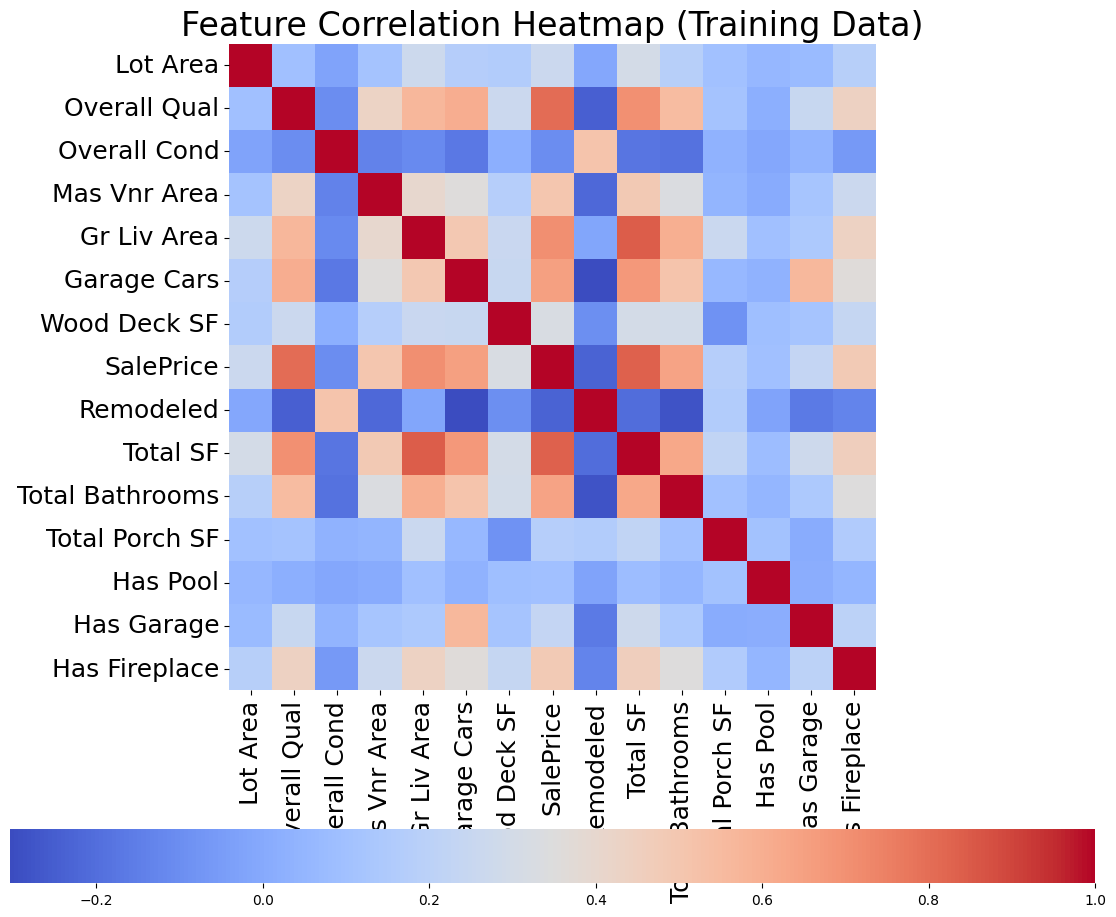

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = dfTrain.select_dtypes(include='number')
corr_matrix = numeric_df.corr()

plt.figure(figsize=(14, 12))
ax = sns.heatmap(
    corr_matrix,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"orientation": "horizontal"}
)
plt.title("Feature Correlation Heatmap (Training Data)", fontsize=24)
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()


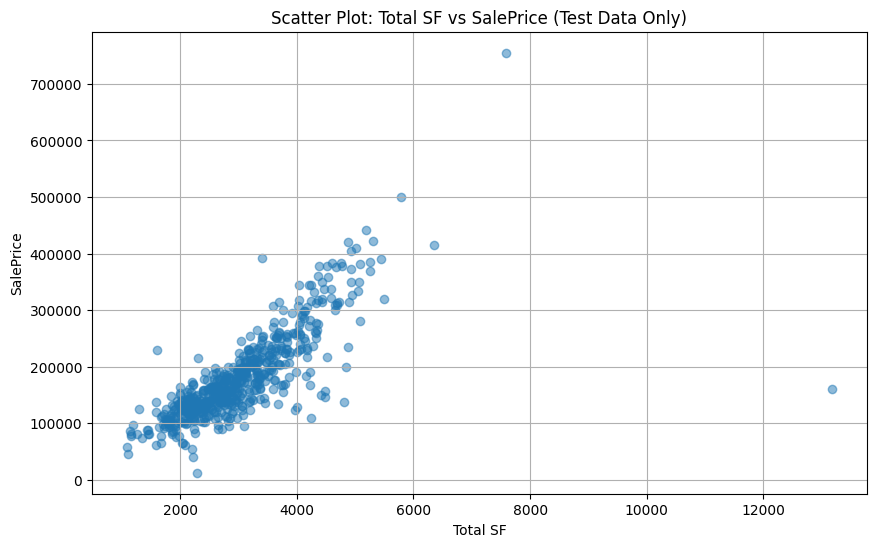

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(dfTest['Total SF'], dfTest['SalePrice'], alpha=0.5)
plt.xlabel('Total SF')
plt.ylabel('SalePrice')
plt.title('Scatter Plot: Total SF vs SalePrice (Test Data Only)')
plt.grid(True)
plt.show()


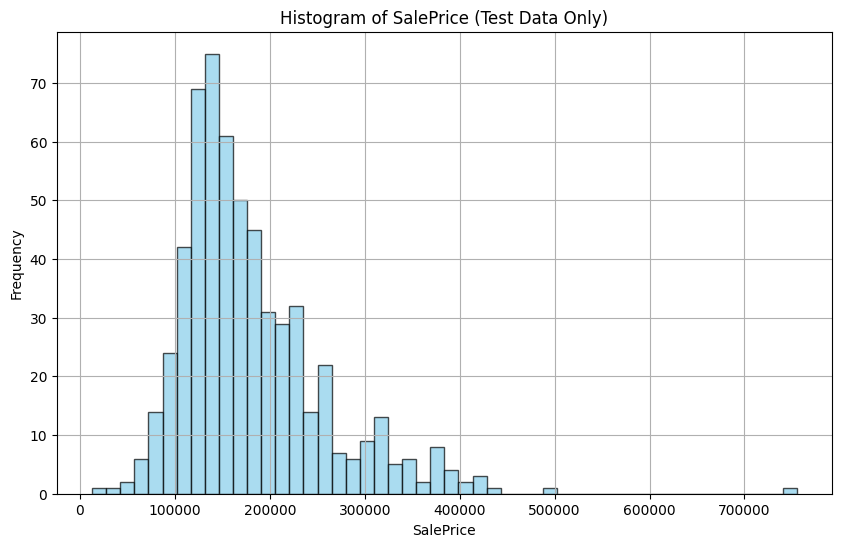

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(dfTest['SalePrice'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('Histogram of SalePrice (Test Data Only)')
plt.grid(True)
plt.show()


In [117]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

numeric_cols = dfTrain.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = dfTrain.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

transformers = [('num', numeric_transform, numeric_cols)]
if len(categorical_cols) > 0:
    transformers.append(('cat', categorical_transform, categorical_cols))

preprocessor = ColumnTransformer(transformers, remainder='drop')

ensambleModel = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2
    ))
])

linearModel = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Train the models
ensambleModel.fit(x_train, y_train)
linearModel.fit(x_train, y_train)



ValueError: Specifying the columns using strings is only supported for dataframes.